In [383]:
# imports
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
import datetime
import tensorflow as tf

**County Level Census Data: https://www.kaggle.com/muonneutrino/us-census-demographic-data#acs2017_county_data.csv**

In [501]:
acs_census = pd.read_csv("data/acs2017_county_data.csv")
acs_census = acs_census.rename(columns={x:x.lower() for x in acs_census.columns})
acs_census = acs_census.rename(columns={"countyid":"fips"})
acs_census.county = acs_census.county.apply(lambda x: x.split('County')[0].rstrip())

**County Level COVID Data: https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv**

In [502]:
covid_by_county = pd.read_csv("data/covid-us-counties.csv")
covid_by_county.date = pd.to_datetime(covid_by_county.date, format="%Y-%m-%d")
covid_by_county = covid_by_county[covid_by_county['fips'] > 0]
covid_by_county.fips = covid_by_county.fips.astype(int)
#covid_by_county = covid_by_county.fillna(0)
#covid_by_county.date = pd.to_numeric(covid_by_county.date)

In [503]:
covid_by_county

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061,1,0
1,2020-01-22,Snohomish,Washington,53061,1,0
2,2020-01-23,Snohomish,Washington,53061,1,0
3,2020-01-24,Cook,Illinois,17031,1,0
4,2020-01-24,Snohomish,Washington,53061,1,0
...,...,...,...,...,...,...
51164,2020-04-11,Sublette,Wyoming,56035,1,0
51165,2020-04-11,Sweetwater,Wyoming,56037,7,0
51166,2020-04-11,Teton,Wyoming,56039,53,0
51167,2020-04-11,Uinta,Wyoming,56041,4,0


In [504]:
# merge on latest date
covid_and_census = pd.merge(covid_by_county[covid_by_county.date == '2020-04-11'], acs_census, on=('county', 'state'), 
                  how = 'inner')
covid_and_census['percentinfected'] = covid_and_census.cases/covid_and_census.totalpop

In [505]:
covid_and_census.corr().style.background_gradient(cmap='magma')

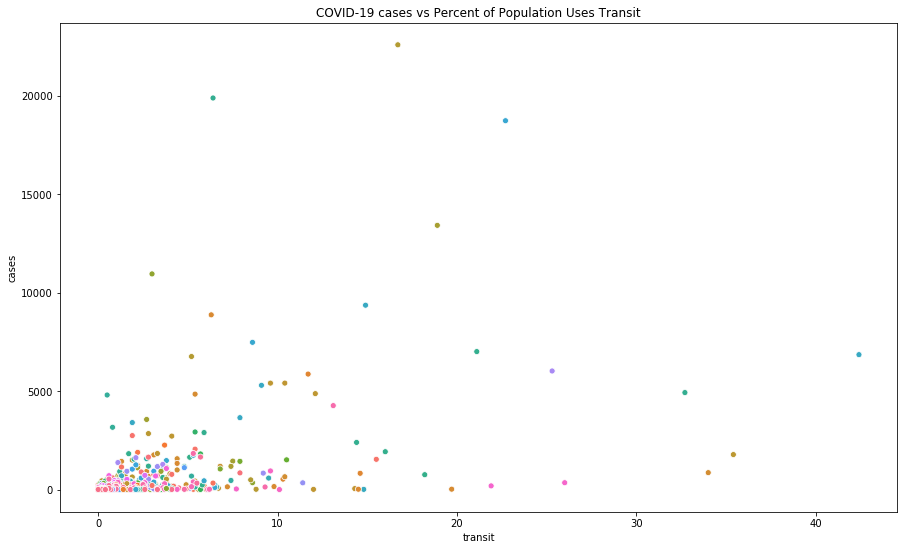

In [506]:
plt.figure(figsize=(15,9))
plt.title('COVID-19 cases vs Percent of Population Uses Transit') # Title
splot = sns.scatterplot(x="transit", y="cases", hue="county", legend=False, data=covid_and_census[covid_and_census['date'] == datetime.datetime(2020,4,11)])
plt.show()

**Is D.C. influencing correlations?**

In [507]:
covid_and_census[covid_and_census.state != "District of Columbia"].corr().style.background_gradient(cmap='magma')

**How do the number of essential workers, population density, and means of transportation affect spread?**

In [508]:
start = datetime.datetime(2020,3,11)
end = datetime.datetime(2020,4,11)
last30 = covid_by_county[(covid_by_county.date > start) & (covid_by_county.date < end)]
last30 = last30[(last30.county == 'Houston') & (last30.state == 'Alabama')]
last30.date = pd.to_numeric(last30.date)
last30.date.corr(last30.cases)

0.9549164248532341

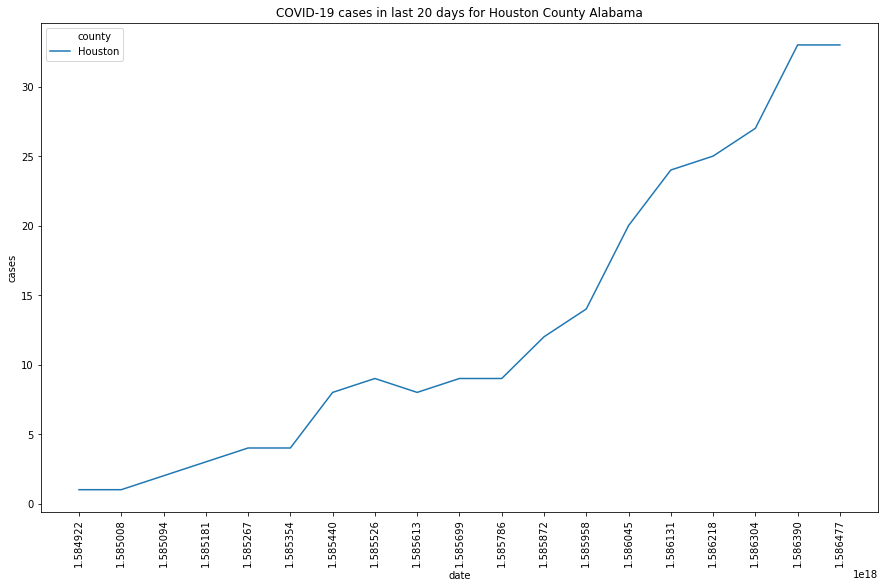

In [509]:
plt.figure(figsize=(15,9))
plt.title('COVID-19 cases in last 20 days for Houston County Alabama') # Title
sns.lineplot(x="date", y="cases", hue="county",data=last30)
plt.xticks(last30.date.unique(), rotation=90) # All values in the x axis rotate 90 degrees
plt.show()

In [510]:
start = datetime.datetime(2020,3,22)
end = datetime.datetime(2020,4,11)
last20days = covid_by_county[(covid_by_county.date >= start) & (covid_by_county.date <= end)]
# Convert dates to integers to get correlation
numeric_datetimes = pd.to_numeric(last20days.date)
last20days.date = numeric_datetimes

/Users/brandonbakr/opt/miniconda3/envs/ds/lib/python3.6/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [511]:
# Group by FIPS
corr_last20days = last20days.groupby('fips')[['date','cases']].corr().iloc[0::2,-1].fillna(0)
corr_last20days

fips       
1001   date    0.961216
1003   date    0.972938
1005   date    0.920895
1007   date    0.976190
1009   date    0.956443
                 ...   
56035  date    0.000000
56037  date    0.968729
56039  date    0.991849
56041  date    0.906693
56043  date    0.920837
Name: cases, Length: 2649, dtype: float64

In [512]:
# Fips in linear regime
linear_last_20_days = corr_last20days[corr_last20days > 0.9]
# Get fips codes for counties in linear regime
target_fips = linear_last_20_days.reset_index(level=[1]).index

In [513]:
linear_counties_last_20days = last20days[last20days.fips.isin(target_fips)]
linear_counties_last_20days = linear_counties_last_20days.sort_values(by=['date'])

In [514]:
# Calculate slope
datetimes = pd.to_datetime(linear_counties_last_20days.date)
linear_counties_last_20days.date = datetimes
firstlast = linear_counties_last_20days.groupby('fips').agg(['first','last'])
firstlast['date'].iloc[:,1]-firstlast['date'].iloc[:,0]
cases_per_day = (firstlast['cases'].iloc[:,1]-firstlast['cases'].iloc[:,0])#/(firstlast['date'].iloc[:,1]-firstlast['date'].iloc[:,0]).apply(lambda x: x.days)

In [515]:
#cases_per_day
census_with_cases_per_day = pd.merge(cases_per_day.rename('cases_per_day'), acs_census, on=('fips'), how = 'inner')
#census_with_cases_per_day['cases_per_day_per_pop'] = 100.*census_with_cases_per_day['cases_per_day']/census_with_cases_per_day['totalpop']
census_with_cases_per_day.corr().style.background_gradient(cmap='magma')

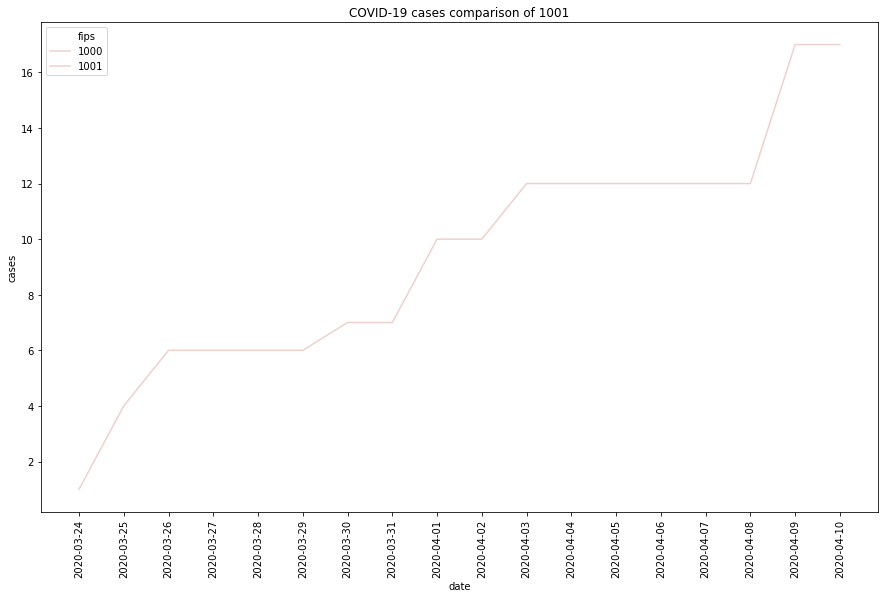

In [516]:
plt.figure(figsize=(15,9))
plt.title('COVID-19 cases comparison of 1001') # Title
sns.lineplot(x="date", y="cases", hue="fips", data=linear_counties_last_30days[linear_counties_last_30days.fips == 1001])
plt.xticks(linear_counties_last_30days[linear_counties_last_30days.fips == 1001].date.unique(), rotation=90) 
plt.show()

In [517]:
training_df = census_with_cases_per_day[['totalpop', 'hispanic', 'white', 'black', 'native', 'asian', 'pacific',
                                         'office', 'construction', 'production', 'drive', 'carpool', 
                                         'transit','walk', 'othertransp', 'workathome', 'meancommute',
                                         'privatework', 'publicwork', 'selfemployed','cases_per_day']]
                                #         'privatework', 'publicwork', 'selfemployed','cases_per_day_per_pop']]

In [518]:
training_df = census_with_cases_per_day[['office', 'construction', 'production', 'drive', 'carpool', 
                                         'transit','walk', 'othertransp', 'workathome', 'meancommute',
                                         'privatework', 'publicwork', 'selfemployed','cases_per_day']]

In [519]:
training_df = census_with_cases_per_day[['drive','carpool','transit','walk','othertransp','cases_per_day']]

In [520]:
#target = training_df.pop('cases_per_day_per_pop')
target = training_df.pop('cases_per_day')

In [521]:
tf_dataset = tf.data.Dataset.from_tensor_slices((training_df.values, target.values))
for feat, targ in tf_dataset.take(5):
  print ('Features: {}, Target: {}'.format(feat, targ))

Features: [86.   9.6  0.1  0.6  1.3], Target: 18
Features: [84.7  7.6  0.1  0.8  1.1], Target: 64
Features: [83.4 11.1  0.3  2.2  1.7], Target: 9
Features: [86.4  9.5  0.7  0.3  1.7], Target: 11
Features: [86.8 10.2  0.1  0.4  0.4], Target: 11


In [522]:
# Define model
def get_compiled_model():
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dense(1)
  ])

    model.compile(optimizer='adam',
                loss="mean_squared_error",
                metrics=['accuracy'])
    return model

In [523]:
train_dataset = tf_dataset.shuffle(len(training_df)).batch(1)
model = get_compiled_model()
model.fit(train_dataset, epochs=15)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1/15
1718/1718 [==============================] - 21s 12ms/step - loss: 1234008.2827 - accuracy: 0.00129050.6911  - 3s 18ms/step - loss: 944985.8830 - accuracy: 0.0000e+0 - 3s 18ms/step - loss: 939164.4999 - ac - 3s 18ms/step - loss: 905674. - 4s 15ms/step - loss: 641 - 18s - 19s 12ms/step - loss: 1301433.7409  - 19s 1 - 21s 12ms/ste
Epoch 2/15
1718/1718 [==============================] - 6s 3ms/step - loss: 1219179.9348 - accuracy: 0.0012
Epoch 3/15
1718/1718 [==============================] - 6s

KeyboardInterrupt: 